# Image Segmentation for EyeWear Extraction 
## Overview
This project is developed to segment eyewear from the background and enhance them for display as catalogue images in the website. The algorithm depends on 
* Yolo-NAS Object Detection Model
    * To detect Eyewear, turntable and background
* Segment AnyThing Model (Facebook Research)
    * To segment the mask out of the Detection boxes
* ML model based Image enhancement (CV handcrafted Models)
    * Image Enhancement for better Resolution & Sharpness

## Project Setup
### Path setup

In [ ]:
!nvidia-smi

## Add Parameters

In [1]:
import os

In [2]:
OBJ_MODEL_ARCH = 'yolo_nas_l'
MODEL_TYPE = "vit_h"
SAM_MODEL_ARCH = "sam_vit_h_4b8939.pth"
IMAGE_TYPE = '.jpeg'
WORKSPACE = os.getcwd()
MODEL_DIR = os.path.join(WORKSPACE, "../models/pth")
TEST_DIR = os.path.join(WORKSPACE, "../data/test/Input_JPEG")

In [3]:
print("WORKSPACE:", WORKSPACE)
print("MODEL DIR:", MODEL_DIR)

WORKSPACE: /workspace/cvspace/notebook
MODEL DIR: /workspace/cvspace/notebook/../models/pth


### Download Necessary Models 

In [4]:
MODEL_PATH = os.path.join(MODEL_DIR, SAM_MODEL_ARCH)
if not os.path.exists(MODEL_PATH):
    !wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {MODEL_PATH}

### Imports

In [5]:
import torch
import cv2
import numpy
from matplotlib import pyplot as plt
from super_gradients.training import models
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from matplotlib import pyplot as plt
import supervision as sv

[2024-01-22 09:13:09] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2024-01-22 09:13:09] WARNING - __init__.py - Failed to import pytorch_quantization


The console stream is logged into /root/sg_logs/console.log


[2024-01-22 09:13:10] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-01-22 09:13:10] WARNING - export.py - Failed to import pytorch_quantization
[2024-01-22 09:13:10] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2024-01-22 09:13:10] INFO - env_sanity_check.py - Library check is not supported when super_gradients installed through "git+https://github.com/..." command


### Load Models
* SAM
* OD - YOLO-NAS

In [6]:
# Setup Device First
DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"

In [7]:
# Load SAM Model
# sam_model = sam_model_registry[MODEL_TYPE](checkpoint=MODEL_PATH).to(device=DEVICE)

In [8]:
od_model = models.get(OBJ_MODEL_ARCH, pretrained_weights="coco").to(DEVICE)

[2024-01-22 09:13:18] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-01-22 09:13:18] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l


## Load test Images from the Test Image Directory

In [10]:
impaths = list()
for root, dirs, files in os.walk(TEST_DIR):
    for file in files:
        if file.endswith(IMAGE_TYPE):
            impaths.append(os.path.join(root, file))

print("{} test images found.".format(len(impaths)))

8 test images found.


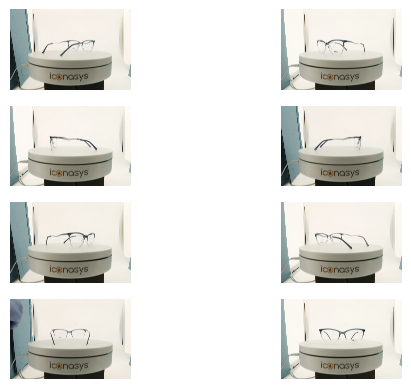

In [11]:
%matplotlib inline
for idx, impath in enumerate(impaths):
    img = cv2.imread(impath)
    #Show the image with matplotlib
    plt.subplot(4, 2, idx+1)
    plt.axis('off')
    plt.imshow(img)

## Object Detection 

In [22]:
image_bgr = cv2.imread(impaths[7])
image_bgr = cv2.resize(image_bgr, (1200, 720), interpolation = cv2.INTER_LINEAR)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

In [23]:
result = list(od_model.predict(image_rgb, conf=0.15))[0]

[2024-01-22 09:25:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


In [24]:
detections = sv.Detections(
    xyxy=result.prediction.bboxes_xyxy,
    confidence=result.prediction.confidence,
    class_id=result.prediction.labels.astype(int)
)

box_annotator = sv.BoxAnnotator()

labels = [
    f"{result.class_names[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _
    in detections
]

annotated_frame = box_annotator.annotate(
    scene=image_rgb.copy(),
    detections=detections,
    labels=labels
)

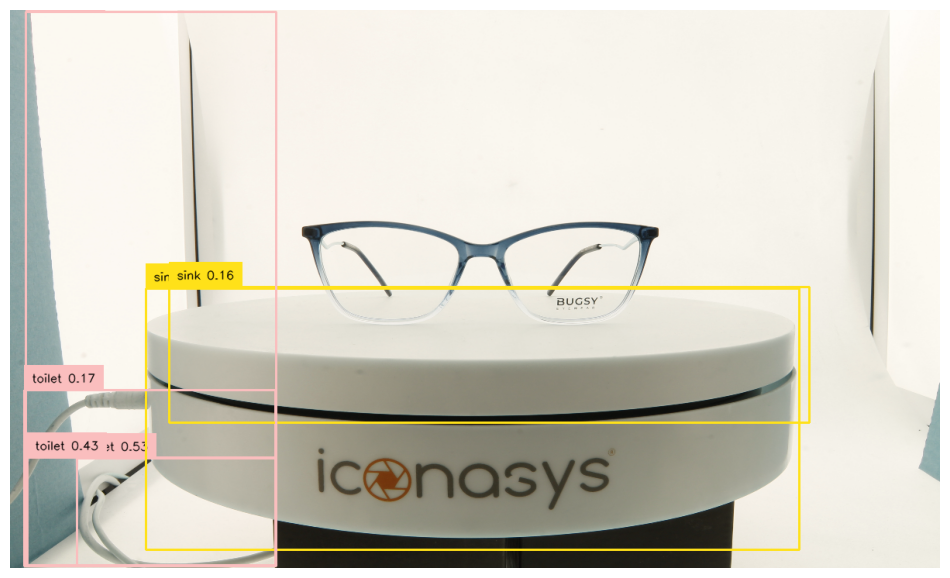

In [25]:
%matplotlib inline
sv.plot_image(annotated_frame, (12, 12))

## Detection and SAM Model 

In [ ]:
image_bgr = cv2.imread(impaths[0])
image_bgr = cv2.resize(image_bgr, (1200, 720), interpolation = cv2.INTER_LINEAR)
mask_generator = SamAutomaticMaskGenerator(sam_model)

In [ ]:
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
sam_result = mask_generator.generate(image_rgb)

In [ ]:
%matplotlib inline
for idx, ires in enumerate(sam_result):
    start = (sam_result[idx]["bbox"][0], sam_result[idx]["bbox"][1])
    end = (sam_result[idx]["bbox"][2], sam_result[idx]["bbox"][3])
    test_img = cv2.rectangle(image_bgr, start, end, (200, 0, 200), 2)
    plt.imshow(test_img)
    plt.show()
    

In [ ]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=sam_result)
annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)